In [1]:
import mdtraj as md
import numpy as np
import pickle
import os
from tqdm import tqdm_notebook
from simtk.openmm import app

## Load htf and trajs for analysis

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/83"
i = 83
phase = 'complex'
cycle = 0

In [3]:
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [7]:
with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_forward_neq_new.npy"), 'rb') as f:
    neq_new = np.load(f)

In [8]:
with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_reverse_neq_new.npy"), 'rb') as f:
    neq_reverse_new = np.load(f)

In [9]:
modeller = app.Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
modeller.deleteWater()

In [10]:
top = md.Topology.from_openmm(modeller.topology)

In [11]:
traj = md.Trajectory(np.array(neq_new), top)


In [ ]:
def new_positions(hybrid_positions):
    n_atoms_new = htf._topology_proposal.n_atoms_new
    hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
    return hybrid_positions[hybrid_indices, :]
    
def old_positions(hybrid_positions):
    n_atoms_old = htf._topology_proposal.n_atoms_old
    hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
    return hybrid_positions[hybrid_indices, :]

def make_traj(outdir, htf, i, phase, name, endstate, is_old=True, solvent_only=False):
    with open(os.path.join(outdir, f"{i}_{phase}_{name}_1ns_snapshots.npy"), "rb") as f:
        cache = np.load(f)
    if is_old:
        old_pos = np.zeros(shape=(100, htf._topology_proposal.old_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            old_pos[j] = old_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))
    else:
        new_pos = np.zeros(shape=(100, htf._topology_proposal.new_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            new_pos[j] = new_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology))
        
    box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
    vectors = np.array([box_vectors]) 
        
    if solvent_only:
        traj.atom_slice(traj.topology.select("water or resname 'na\+' or resn 'cl\-'"), inplace=True)
        
    # Set unit cell vectors in traj 
    traj.unitcell_vectors = np.repeat(vectors, 100, axis=0)
    traj.image_molecules(inplace=True)
    
    if solvent_only:
        traj.save(os.path.join(outdir, f"{i}_{phase}_{endstate}_solvent.dcd"))
        traj[0].save(os.path.join(outdir, f"{i}_{phase}_{endstate}_solvent.pdb"))
    else:
        traj.save(os.path.join(outdir, f"{i}_{phase}_{endstate}.dcd"))
        traj[0].save(os.path.join(outdir, f"{i}_{phase}_{endstate}.pdb"))
    return traj
       

In [12]:
traj_reverse = md.Trajectory(np.array(neq_reverse_new), top)


## Compute chi1 and chi2 angles for Y501 in the last snapshot of fwd switching and the first snapshot of reverse switching

In [13]:
tyr_atoms = []
for atom in top.atoms:
    if atom.residue.resSeq == 501 and atom.residue.name == 'TYR':
        print(atom, atom.residue.resSeq, atom.index)
        tyr_atoms.append(atom.index)

TYR501-N 501 2605
TYR501-H 501 2606
TYR501-CA 501 2607
TYR501-HA 501 2608
TYR501-CB 501 2609
TYR501-HB2 501 2610
TYR501-HB3 501 2611
TYR501-CG 501 2612
TYR501-CD1 501 2613
TYR501-HD1 501 2614
TYR501-CE1 501 2615
TYR501-HE1 501 2616
TYR501-CZ 501 2617
TYR501-OH 501 2618
TYR501-HH 501 2619
TYR501-CE2 501 2620
TYR501-HE2 501 2621
TYR501-CD2 501 2622
TYR501-HD2 501 2623
TYR501-C 501 2624
TYR501-O 501 2625


In [14]:
indices, angles = md.compute_chi1(traj[-1])

In [15]:
for i, index_set in enumerate(indices):
    if set(index_set).intersection(set(tyr_atoms)):
        print(i, index_set)

146 [2605 2607 2609 2612]


In [16]:
indices, angles = md.compute_chi2(traj[-1])

In [17]:
for i, index_set in enumerate(indices):
    if set(index_set).intersection(set(tyr_atoms)):
        print(i, index_set)

104 [2607 2609 2612 2613]


In [18]:
indices, angles = md.compute_chi1(traj_reverse[0])

In [19]:
for i, index_set in enumerate(indices):
    if set(index_set).intersection(set(tyr_atoms)):
        print(i, index_set)

146 [2605 2607 2609 2612]


In [20]:
indices, angles = md.compute_chi2(traj_reverse[0])

In [21]:
for i, index_set in enumerate(indices):
    if set(index_set).intersection(set(tyr_atoms)):
        print(i, index_set)

104 [2607 2609 2612 2613]


In [22]:
forward_chi1, forward_chi2, reverse_chi1, reverse_chi2 = list(), list(), list(), list()
for cycle in tqdm_notebook(range(100)):
    with open(os.path.join(outdir, f"83_{phase}_{cycle}_forward_neq_new.npy"), 'rb') as f:
        neq_new = np.load(f)
    with open(os.path.join(outdir, f"83_{phase}_{cycle}_reverse_neq_new.npy"), 'rb') as f:
        neq_reverse_new = np.load(f)
        
    modeller = app.Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
    modeller.deleteWater()
    top = md.Topology.from_openmm(modeller.topology)
    
    traj = md.Trajectory(np.array(neq_new), top)
    traj_reverse = md.Trajectory(np.array(neq_reverse_new), top)

    chi1_indices, chi1_angles = md.compute_chi1(traj[-1])
    chi2_indices, chi2_angles = md.compute_chi2(traj[-1])
    forward_chi1.append(chi1_angles[:, 146])
    forward_chi2.append(chi2_angles[:, 104])
    
    chi1_indices, chi1_angles = md.compute_chi1(traj_reverse[0])
    chi2_indices, chi2_angles = md.compute_chi2(traj_reverse[0])
    reverse_chi1.append(chi1_angles[:, 146])
    reverse_chi2.append(chi2_angles[:, 104])

<ipython-input-22-acf3466c0dd0>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cycle in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
with open(os.path.join(outdir, "Y501_forward_chi1_angles.pickle"), "wb") as f:
    pickle.dump(forward_chi1, f)
with open(os.path.join(outdir, "Y501_forward_chi2_angles.pickle"), "wb") as f:
    pickle.dump(forward_chi2, f)
with open(os.path.join(outdir, "Y501_reverse_chi1_angles.pickle"), "wb") as f:
    pickle.dump(reverse_chi1, f)
with open(os.path.join(outdir, "Y501_reverse_chi2_angles.pickle"), "wb") as f:
    pickle.dump(reverse_chi2, f)

In [4]:
with open(os.path.join(outdir, "Y501_forward_chi1_angles.pickle"), "rb") as f:
    forward_chi1 = pickle.load(f)
with open(os.path.join(outdir, "Y501_forward_chi2_angles.pickle"), "rb") as f:
    forward_chi2 = pickle.load(f)
with open(os.path.join(outdir, "Y501_reverse_chi1_angles.pickle"), "rb") as f:
    reverse_chi1 = pickle.load(f)
with open(os.path.join(outdir, "Y501_reverse_chi2_angles.pickle"), "rb") as f:
    reverse_chi2 = pickle.load(f)

## Plot chi1 and chi2 angles

In [5]:
import matplotlib.pyplot as plt


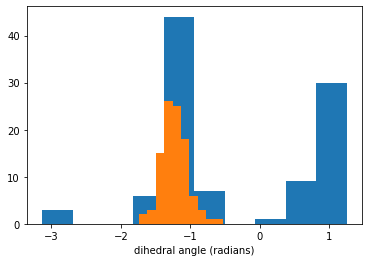

In [6]:
plt.hist([arr[0] for arr in forward_chi1])
plt.hist([arr[0] for arr in reverse_chi1])
plt.xlabel('dihedral angle (radians)')
plt.show()

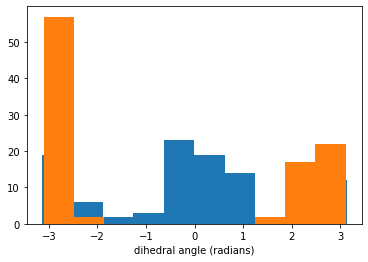

In [7]:
plt.hist([arr[0] for arr in forward_chi2])
plt.hist([arr[0] for arr in reverse_chi2])
plt.xlabel('dihedral angle (radians)')
plt.show()

In [50]:
forward_chi1[0]

array([-1.0462533], dtype=float32)

In [51]:
forward_chi1[1]

array([1.1758909], dtype=float32)

In [52]:
forward_chi1[2]

array([1.1641691], dtype=float32)

In [53]:
reverse_chi1[0]

array([-1.0679047], dtype=float32)

In [54]:
reverse_chi1[1]

array([-1.1164703], dtype=float32)

In [55]:
reverse_chi1[2]

array([-1.1484852], dtype=float32)

In [56]:
forward_chi2[0]

array([-0.0900849], dtype=float32)

In [57]:
forward_chi2[1]

array([1.0189208], dtype=float32)

In [58]:
forward_chi2[2]

array([-2.0170689], dtype=float32)

In [59]:
reverse_chi2[0]

array([2.0403852], dtype=float32)

In [60]:
reverse_chi2[1]

array([2.0971842], dtype=float32)

In [61]:
reverse_chi2[2]

array([2.2351425], dtype=float32)

## Cluster the traj indices based on the angles

In [12]:
d_clusters_forward = {-3: [], -1: [], 1: []}
for i, angle in enumerate(forward_chi1):
    if angle <= -2:
        d_clusters_forward[-3].append(i)
    elif angle > -2 and angle < -0.5:
        d_clusters_forward[-1].append(i)
    else:
        d_clusters_forward[1].append(i)

d_clusters_reverse = {-3: [], -1: [], 1: []}
for i, angle in enumerate(reverse_chi1):
    if angle <= -2:
        d_clusters_reverse[-3].append(i)
    elif angle > -2 and angle < -0.5:
        d_clusters_reverse[-1].append(i)
    else:
        d_clusters_reverse[1].append(i)

In [29]:
d_clusters_forward_chi2 = {-3: [], 0: [], 3: []}
for i, angle in enumerate(forward_chi2):
    if angle <= -1:
        d_clusters_forward_chi2[-3].append(i)
    elif angle > -1 and angle < 1:
        d_clusters_forward_chi2[0].append(i)
    else:
        d_clusters_forward_chi2[3].append(i)

d_clusters_reverse_chi2 = {-3: [], 0: [], 3: []}
for i, angle in enumerate(reverse_chi2):
    if angle <= -1:
        d_clusters_reverse_chi2[-3].append(i)
    elif angle > -1 and angle < 1:
        d_clusters_reverse_chi2[0].append(i)
    else:
        d_clusters_reverse_chi2[3].append(i)

## Plot the work values for each cluster

In [8]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [9]:
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    

In [10]:
# Load data into dicts and plot 
titles = ["A501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 83
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
#     plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
#     plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 83
job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9
job: 10
job: 11
job: 12
job: 13
job: 14
job: 15
job: 16
job: 17
job: 18
job: 19
job: 20
job: 21
job: 22
job: 23
job: 24
job: 25
job: 26
job: 27
job: 28
job: 29
job: 30
job: 31
job: 32
job: 33
job: 34
job: 35
job: 36
job: 37
job: 38
job: 39
job: 40
job: 41
job: 42
job: 43
job: 44
job: 45
job: 46
job: 47
job: 48
job: 49
job: 50
job: 51
job: 52
job: 53
job: 54
job: 55
job: 56
job: 57
job: 58
job: 59
job: 60
job: 61
job: 62
job: 63
job: 64
job: 65
job: 66
job: 67
job: 68
job: 69
job: 70
job: 71
job: 72
job: 73
job: 74
job: 75
job: 76
job: 77
job: 78
job: 79
job: 80
job: 81
job: 82
job: 83
job: 84
job: 85
job: 86
job: 87
job: 88
job: 89
job: 90
job: 91
job: 92
job: 93
job: 94
job: 95
job: 96
job: 97
job: 98
job: 99
100
job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9
job: 10
job: 11
job: 12
job: 13
job: 14
job: 15
job: 16
job: 17
job: 18
job: 19
job: 20
job: 21
job: 22
job: 23
job: 24
job: 25


#### Chi1 angles

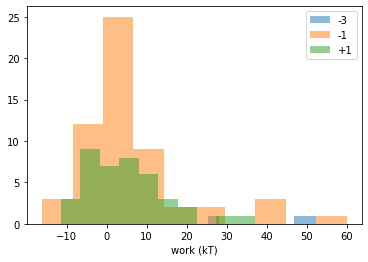

In [17]:
plt.hist(d_works['complex']['forward'][d_clusters_forward[-3]], alpha=0.5, label='-3')
plt.hist(d_works['complex']['forward'][d_clusters_forward[-1]], alpha=0.5, label='-1')
plt.hist(d_works['complex']['forward'][d_clusters_forward[1]], alpha=0.5, label='+1')
plt.xlabel("work (kT)")
plt.legend()
plt.show()

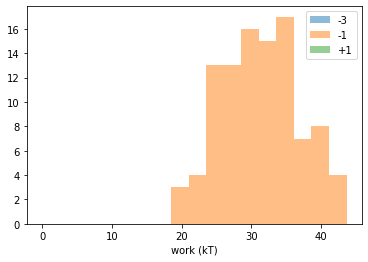

In [19]:
plt.hist(d_works['complex']['reverse'][d_clusters_reverse[-3]], alpha=0.5, label='-3')
plt.hist(d_works['complex']['reverse'][d_clusters_reverse[-1]], alpha=0.5, label='-1')
plt.hist(d_works['complex']['reverse'][d_clusters_reverse[1]], alpha=0.5, label='+1')
plt.xlabel("work (kT)")
plt.legend()
plt.show()

#### Chi2 angles

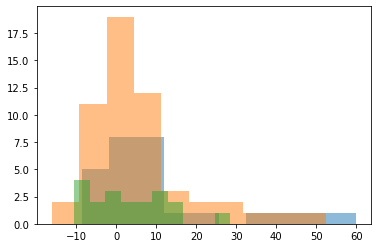

In [31]:
plt.hist(d_works['complex']['forward'][d_clusters_forward_chi2[-3]], alpha=0.5)
plt.hist(d_works['complex']['forward'][d_clusters_forward_chi2[0]], alpha=0.5)
plt.hist(d_works['complex']['forward'][d_clusters_forward_chi2[3]], alpha=0.5)
plt.show()

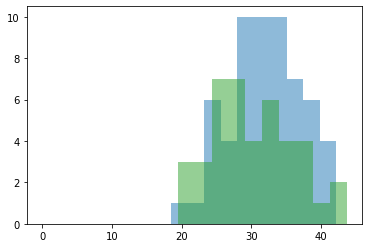

In [32]:
plt.hist(d_works['complex']['reverse'][d_clusters_reverse_chi2[-3]], alpha=0.5)
plt.hist(d_works['complex']['reverse'][d_clusters_reverse_chi2[0]], alpha=0.5)
plt.hist(d_works['complex']['reverse'][d_clusters_reverse_chi2[3]], alpha=0.5)
plt.show()

In [27]:
d_works['complex']['forward']

array([ 1.25188393e-01,  1.99830523e-01,  1.28386148e+00,  2.88008830e+00,
        1.47379796e+00, -3.86308952e+00, -2.50999366e+00,  4.75070119e+01,
        2.27681101e+00, -2.87547939e+00, -5.47289745e+00,  1.60363480e+01,
        5.14247720e+00,  3.24053210e-01, -3.88092305e+00,  5.71869358e+00,
       -1.77832641e+00,  1.07395967e+01,  1.10173945e+00, -3.46091638e+00,
        2.17585011e+01,  1.04975187e+01,  5.05537364e+00, -4.37607678e+00,
       -7.87836778e+00,  6.68613881e+00,  6.53509143e+00,  6.77646261e+00,
        8.99663228e+00,  3.83233639e+00,  4.42865088e+01,  3.76714195e+01,
        1.57410313e+01,  1.09627510e+01,  1.00378801e+01,  2.10501681e+00,
       -1.15716738e+00, -1.05611635e+01,  1.44933276e+01,  1.07924040e+00,
       -8.12792405e-01,  3.87264411e+00,  2.21598174e+00,  3.63317241e-02,
       -7.92103031e+00,  1.44787951e+00,  1.25932892e+01,  2.54023636e+01,
        6.00014181e+01,  4.61455664e+00, -8.54829633e+00,  4.55898555e+00,
        4.72127556e+00,  